# Transfer Learning with Ada Embeddings
copyright 2023, Denis Rothman, MIT License


The reference [OpenAI Embedding and Clustering Cookbook](https://github.com/openai/openai-cookbook/blob/main/examples/Clustering.ipynb) was modified by Denis Rothman for educational purposes.

# Installing OpenAI

In [1]:
try:
  import openai
except:
  !pip install openai
  import openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 9.2 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
f = open("drive/MyDrive/files/api_key.txt", "r")
API_KEY=f.readline()
f.close()

In [4]:
import os
os.environ['OPENAI_API_KEY'] =API_KEY
openai.api_key = os.getenv("OPENAI_API_KEY")

# Installing tiktoken

In [5]:
!pip install tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 77.0 MB/s eta 0:00:00


# Installing Kaggle

In [6]:
import json
with open(os.path.expanduser("drive/MyDrive/files/kaggle.json"), "r") as f:
    kaggle_credentials = json.load(f)

kaggle_username = kaggle_credentials["username"]
kaggle_key = kaggle_credentials["key"]

os.environ["KAGGLE_USERNAME"] = kaggle_username
os.environ["KAGGLE_KEY"] = kaggle_key

In [7]:
try:
  import kaggle
except:
  !pip install kaggle
  import kaggle

In [8]:
kaggle.api.authenticate()

# 1.The Amazon Fine Food Reviews Dataset

## 1.1. Download the dataset


### Amazon Fine Food Reviews

https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews


In [9]:
!kaggle datasets download -d snap/amazon-fine-food-reviews

 99% 239M/242M [00:12<00:00, 22.1MB/s]
100% 242M/242M [00:12<00:00, 19.8MB/s]


In [10]:
import zipfile

zip_file_path = '/content/amazon-fine-food-reviews.zip'
csv_file_name = 'Reviews.csv'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extract(csv_file_name)

##  1.2. Data preparation

In [11]:
# imports
import pandas as pd
import tiktoken

from openai.embeddings_utils import get_embedding

In [12]:
# embedding model parameters
embedding_model = "text-embedding-ada-002"
embedding_encoding = "cl100k_base"  # this the encoding for text-embedding-ada-002
max_tokens = 8000  # the maximum for text-embedding-ada-002 is 8191

In [13]:
# load & inspect dataset
input_datapath = "/content/Reviews.csv"  # to save space, we provide a pre-filtered dataset
df = pd.read_csv(input_datapath, index_col=0)
df = df[["Time", "ProductId", "UserId", "Score", "Summary", "Text"]]
df = df.dropna()
df["combined"] = (
    "Title: " + df.Summary.str.strip() + "; Content: " + df.Text.str.strip()
)
df.head(10)

,Time,ProductId,UserId,Score,Summary,Text,combined
Id,,,,,,,
1,1303862400,B001E4KFG0,A3SGXH7AUHU8GW,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,Title: Good Quality Dog Food; Content: I have ...
2,1346976000,B00813GRG4,A1D87F6ZCVE5NK,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,Title: Not as Advertised; Content: Product arr...
3,1219017600,B000LQOCH0,ABXLMWJIXXAIN,4,"""Delight"" says it all",This is a confection that has been around a fe...,"Title: ""Delight"" says it all; Content: This is..."
4,1307923200,B000UA0QIQ,A395BORC6FGVXV,2,Cough Medicine,If you are looking for the secret ingredient i...,Title: Cough Medicine; Content: If you are loo...
5,1350777600,B006K2ZZ7K,A1UQRSCLF8GW1T,5,Great taffy,Great taffy at a great price. There was a wid...,Title: Great taffy; Content: Great taffy at a ...
6,1342051200,B006K2ZZ7K,ADT0SRK1MGOEU,4,Nice Taffy,I got a wild hair for taffy and ordered this f...,Title: Nice Taffy; Content: I got a wild hair ...
7,1340150400,B006K2ZZ7K,A1SP2KVKFXXRU1,5,Great! Just as good as the expensive brands!,This saltwater taffy had great flavors and was...,Title: Great! Just as good as the expensive b...
8,1336003200,B006K2ZZ7K,A3JRGQVEQN31IQ,5,"Wonderful, tasty taffy",This taffy is so good. It is very soft and ch...,"Title: Wonderful, tasty taffy; Content: This t..."
9,1322006400,B000E7L2R4,A1MZYO9TZK0BBI,5,Yay Barley,Right now I'm mostly just sprouting this so my...,Title: Yay Barley; Content: Right now I'm most...


In [14]:
# subsample to 1k most recent reviews and remove samples that are too long
top_n = 1000
df = df.sort_values("Time").tail(top_n * 2)  # first cut to first 2k entries, assuming less than half will be filtered out
df.drop("Time", axis=1, inplace=True)

encoding = tiktoken.get_encoding(embedding_encoding)

# omit reviews that are too long to embed
df["n_tokens"] = df.combined.apply(lambda x: len(encoding.encode(x)))
df = df[df.n_tokens <= max_tokens].tail(top_n)
len(df)

1000

# 2.Running Ada embeddings and saved for future reuse

In [15]:
# Ensure you have your API key set in your environment per the README: https://github.com/openai/openai-python#usage

# This may take a few minutes
df["embedding"] = df.combined.apply(lambda x: get_embedding(x, engine=embedding_model))
df.to_csv("fine_food_reviews_with_embeddings_1k.csv")

## Save the embeddings to Google Drive or another location

In [16]:
#f = open("drive/MyDrive/files/api_key.txt", "r")
!cp /content/fine_food_reviews_with_embeddings_1k.csv drive/MyDrive/files/fine_food_reviews_with_embeddings_1k.csv

# 3.Clustering

We use a simple k-means algorithm to demonstrate how clustering can be done. Clustering can help discover valuable, hidden groupings within the data. The dataset is created in the [Obtain_dataset Notebook](Obtain_dataset.ipynb).

In [17]:
# imports
import numpy as np
import pandas as pd

# load data
datafile_path = "fine_food_reviews_with_embeddings_1k.csv"

#df = pd.read_csv(datafile_path)
# read the csv file skipping bad lines
df = pd.read_csv('fine_food_reviews_with_embeddings_1k.csv', error_bad_lines=False)

# count number of lines in the dataframe
df_line_count = len(df)

# count total lines in the csv file
with open('fine_food_reviews_with_embeddings_1k.csv') as f:
    total_line_count = sum(1 for _ in enumerate(f))

# calculate number of bad lines
bad_lines = total_line_count - df_line_count
print(f'Number of bad lines: {bad_lines}')



df["embedding"] = df.embedding.apply(eval).apply(np.array)  # convert string to numpy array
matrix = np.vstack(df.embedding.values)
matrix.shape


<ipython-input-17-cef2d1d77f6f>:10: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv('fine_food_reviews_with_embeddings_1k.csv', error_bad_lines=False)


Number of bad lines: 1


(1000, 1536)

### 3.1. Find the clusters using K-means

We show the simplest use of K-means. You can pick the number of clusters that fits your use case best.

In [18]:
from sklearn.cluster import KMeans

n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(matrix)
labels = kmeans.labels_
df["Cluster"] = labels

df.groupby("Cluster").Score.mean().sort_values()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster
2    4.081560
1    4.191176
0    4.221805
3    4.344937
Name: Score, dtype: float64

### 3.2.Display Clusters with T-SNE

Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

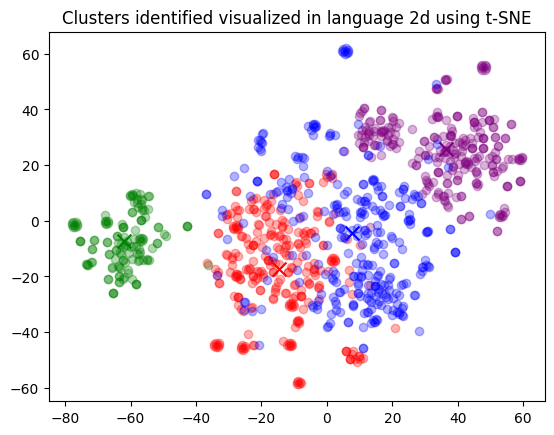

In [19]:
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue"]):
    xs = np.array(x)[df.Cluster == category]
    ys = np.array(y)[df.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)
plt.title("Clusters identified visualized in language 2d using t-SNE")


Visualization of clusters in a 2d projection. In this run, the green cluster (#1) seems quite different from the others. Let's see a few samples from each cluster.

# 4.Text samples in the clusters & naming the clusters

Let's show random samples from each cluster. We'll use text-davinci-003 to name the clusters, based on a random sample of 5 reviews from that cluster.

In [20]:
import openai

# Reading a review which belong to each group.
rev_per_cluster = 5

for i in range(n_clusters):
    print(f"Cluster {i} Theme:", end=" ")

    reviews = "\n".join(
        df[df.Cluster == i]
        .combined.str.replace("Title: ", "")
        .str.replace("\n\nContent: ", ":  ")
        .sample(rev_per_cluster, random_state=42)
        .values
    )
    response = openai.Completion.create(
        engine="text-davinci-003",
        prompt=f'What do the following customer reviews have in common?\n\nCustomer reviews:\n"""\n{reviews}\n"""\n\nTheme:',
        temperature=0,
        max_tokens=64,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0,
    )
    print(response["choices"][0]["text"].replace("\n", ""))

    sample_cluster_rows = df[df.Cluster == i].sample(rev_per_cluster, random_state=42)
    for j in range(rev_per_cluster):
        print(sample_cluster_rows.Score.values[j], end=", ")
        print(sample_cluster_rows.Summary.values[j], end=":   ")
        print(sample_cluster_rows.Text.str[:70].values[j])

    print("-" * 100)


Cluster 0 Theme:  All of the reviews are positive and discuss the quality of the tea.
5, breakfast tea:   We switch to this decaf tea at night for a great cup of tea and no sle
5, It is awesome.:   My partner is very happy with the tea, and is feeling much better sinc
4, Chike!:   Just tried the orange and iced coffee this morning and really liked th
5, FAVORITE tea...:   Lipton makes the BEST French Vanilla tea...I have tried others and thi
5, Twinings---a good cup of tea:   I have been drinking Twining's tea for years.  It used to be made in E
----------------------------------------------------------------------------------------------------
Cluster 1 Theme:  All of the reviews are positive and discuss the benefits of the product.
5, Dogs love it.:   This is the "all gone" treat after dinner.  It's the only treat that t
2, Triggered strange vomit response to my dog:   I can't deny that these smell amazing- all the fruitables that I order
4, Very convenient:   Before I order anything

It's important to note that clusters will not necessarily match what you intend to use them for. A larger amount of clusters will focus on more specific patterns, whereas a small number of clusters will usually focus on largest discrepencies in the data.